<a href="https://colab.research.google.com/github/varadkulkarni26/LipReading/blob/main/LipReading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

KeyboardInterrupt: 

In [2]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio
import gdown

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
      try:
          tf.config.experimental.set_memory_growth(physical_devices[0], True)
          print(f"GPU detected: {physical_devices[0]}")
      except:
          print("Could not set GPU memory growth")
          pass
else:
      print("No GPU detected, running on CPU")

GPU detected: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# **1. Building Data Loading functions**

In [4]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7de39f06-bc76-4edd-9865-351ebe5f27a1
To: /content/data.zip
100%|██████████| 423M/423M [00:08<00:00, 48.3MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [5]:
def load_video(path:str) -> List[float]:
    cap = cv2.VideoCapture(path)
    frames = []

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count == 0:
        cap.release()
        return tf.zeros((75, 46, 140, 1), dtype=tf.float32)

    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            # Skip frames that could not be read
            continue

        # Ensure frame has 3 channels and is in RGB format, then cast to float32
        if len(frame.shape) == 2:  # Grayscale image (H, W)
            frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR) # Convert to 3-channel BGR
        elif len(frame.shape) == 3 and frame.shape[2] == 4: # RGBA image
            frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR) # Convert RGBA to BGR
        elif not (len(frame.shape) == 3 and frame.shape[2] == 3): # If not a standard 3-channel image (e.g., 1-channel 3D, or other unexpected)
            continue # Skip problematic frame

        # At this point, `frame` should be a NumPy array of shape (H, W, 3) in BGR format.
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to TensorFlow tensor and cast to float32
        frame_tensor = tf.cast(frame_rgb, tf.float32)

        try:
            # Apply grayscale conversion
            frame_grayscale = tf.image.rgb_to_grayscale(frame_tensor)
            frames.append(frame_grayscale[190:236,80:220,:]) # Crop the frame
        except tf.errors.InvalidArgumentError as e:
            print(f"Skipping problematic frame in video {path}: {e}")
            # Append a zero tensor of the expected cropped grayscale shape
            frames.append(tf.zeros((46, 140, 1), dtype=tf.float32))

    cap.release()

    if not frames:
        # If all frames were skipped or video was empty, return a placeholder
        return tf.zeros((75, 46, 140, 1), dtype=tf.float32)

    frames_tensor = tf.convert_to_tensor(frames, dtype=tf.float32)
    mean = tf.math.reduce_mean(frames_tensor)
    std = tf.math.reduce_std(frames_tensor)
    # Add a small epsilon to standard deviation to prevent division by zero
    return (frames_tensor - mean) / (std + 1e-7)

In [6]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [7]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_("'"), np.str_('?'), np.str_('!'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(' ')] (size =40)


In [8]:
char_to_num.get_vocabulary()

['',
 np.str_('a'),
 np.str_('b'),
 np.str_('c'),
 np.str_('d'),
 np.str_('e'),
 np.str_('f'),
 np.str_('g'),
 np.str_('h'),
 np.str_('i'),
 np.str_('j'),
 np.str_('k'),
 np.str_('l'),
 np.str_('m'),
 np.str_('n'),
 np.str_('o'),
 np.str_('p'),
 np.str_('q'),
 np.str_('r'),
 np.str_('s'),
 np.str_('t'),
 np.str_('u'),
 np.str_('v'),
 np.str_('w'),
 np.str_('x'),
 np.str_('y'),
 np.str_('z'),
 np.str_("'"),
 np.str_('?'),
 np.str_('!'),
 np.str_('1'),
 np.str_('2'),
 np.str_('3'),
 np.str_('4'),
 np.str_('5'),
 np.str_('6'),
 np.str_('7'),
 np.str_('8'),
 np.str_('9'),
 np.str_(' ')]

In [9]:
char_to_num(['v','a','r','a','d'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([22,  1, 18,  1,  4])>

In [10]:
num_to_char([22,  1, 18,  1,  4])

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'v', b'a', b'r', b'a', b'd'], dtype=object)>

In [47]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]

    # Explicitly convert the Python list of strings to a TensorFlow tensor of strings
    tokens_tensor = tf.constant(tokens, dtype=tf.string)
    # Split each string in the tensor into unicode characters, resulting in a RaggedTensor
    split_tokens = tf.strings.unicode_split(tokens_tensor, input_encoding='UTF-8')
    # Flatten the RaggedTensor to a 1D dense tensor of individual characters
    flattened_tokens = split_tokens.flat_values

    # Apply char_to_num and slice from the second element
    return char_to_num(flattened_tokens)[1:]

In [60]:
def load_data(path: str):
    path_str = bytes.decode(path.numpy()).replace('\\', '/') # Normalize path separators
    base_name = os.path.basename(path_str)
    file_name, _ = os.path.splitext(base_name) # Get filename without extension

    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [13]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [14]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path.replace('\\', '/').lstrip('./')))

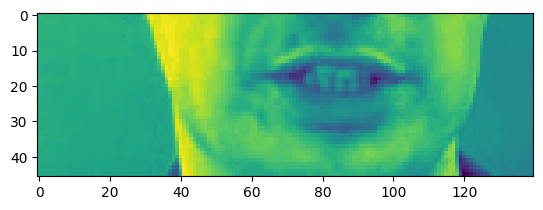

In [16]:
plt.imshow(frames[35])

In [17]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [19]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# **2. Creating Data Pipeline**

In [20]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# # Added for split
train = data.take(450)
test = data.skip(450)

In [21]:
len(test)

50

In [22]:
frames, alignments = data.as_numpy_iterator().next()

In [23]:
len(frames)

2

In [24]:
sample = data.as_numpy_iterator()

In [25]:
val = sample.next(); val[0]

array([[[[[ 0.09318843],
          [ 0.09318843],
          [ 0.09318843],
          ...,
          [ 0.05804724],
          [-0.03406069],
          [-0.5970355 ]],

         [[ 0.09318843],
          [ 0.09318843],
          [ 0.09318843],
          ...,
          [-0.50492823],
          [-0.90017563],
          [-1.2899274 ]],

         [[ 0.05035087],
          [ 0.05035087],
          [ 0.05035087],
          ...,
          [-1.14169   ],
          [-1.1249511 ],
          [-1.1249511 ]],

         ...,

         [[-0.24524489],
          [-0.24524489],
          [-0.24524489],
          ...,
          [-1.293717  ],
          [-1.3031241 ],
          [-1.3031241 ]],

         [[-0.24524489],
          [-0.24524489],
          [-0.24524489],
          ...,
          [-1.3777258 ],
          [-1.3897356 ],
          [-1.3897356 ]],

         [[-0.24524489],
          [-0.24524489],
          [-0.24524489],
          ...,
          [-1.3777258 ],
          [-1.3897356 ],
          

In [26]:
import tensorflow as tf

# Rescale values to 0-255 and convert to uint8
min_val = tf.reduce_min(val[0][0])
max_val = tf.reduce_max(val[0][0])
scaled_frames = (val[0][0] - min_val) / (max_val - min_val) * 255
scaled_frames = tf.cast(scaled_frames, tf.uint8)

# Squeeze the last dimension (channel dimension) for grayscale images
squeezed_frames = tf.squeeze(scaled_frames, axis=-1)

imageio.mimsave('./animation.gif', squeezed_frames, fps=10)

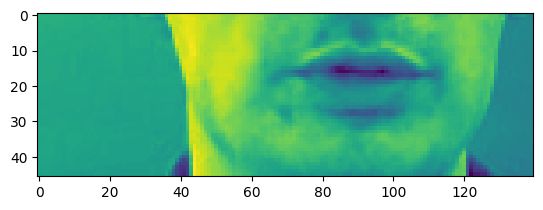

In [27]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [28]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place red with q four please'>

## **3. Designing the Deep Neural Network**

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [30]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [31]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Reshape((75, 5 * 17 * 75))) # Explicit reshape here

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 75, 46, 140,    │         3,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 75, 46, 140,    │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 75, 23, 70,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 75, 23, 70,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 75, 23, 70,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 75, 11, 35,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 75, 11, 35, 75) │       518,475 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 75, 11, 35, 75) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 75, 5, 17, 75)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 75, 6375)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 75, 256)        │     6,660,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 75, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 75, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75, 41)         │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,471,924 (32.32 MB)

 Trainable params: 8,471,924 (32.32 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
5*17*75

6375

In [34]:
yhat = model.predict(val[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [35]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'yyyyhhhddh888888888888888888888888888888888888888888888888888888888888888rr'>

In [36]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'yyyyhhhddh888888888888888888888888888888888888888888888888888888888888888rr'>

In [37]:
model.input_shape

(None, 75, 46, 140, 1)

In [38]:
model.output_shape

(None, 75, 41)

### **4. Setting up Training Options and Train**

In [39]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [40]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [41]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [43]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint.weights.h5'), monitor='loss', save_weights_only=True)

In [44]:
schedule_callback = LearningRateScheduler(scheduler)

In [45]:
example_callback = ProduceExample(test)

In [59]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 66.0469

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:3 transformation with iterator: Iterator::Root::Prefetch::FiniteSkip::Prefetch::PaddedBatchV2::Map: InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/
Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-454100477.py", line 9, in load_data
    alignments = load_alignments(alignment_path)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipython-input-1342149016.py", line 9, in load_alignments
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/usr/local/lib/python3.12/dist-packages/tensorflow/python/framework/ops.py", line 6006, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: strided_slice/


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

## **5. Making Prediction**

In [49]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=c012d7c4-1fad-4d86-809c-325b48c7a196
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 90.2MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [50]:
model.load_weights('models/checkpoint.weights.h5')

In [51]:
test_data = test.as_numpy_iterator()

In [52]:
sample = test_data.next()

In [53]:
yhat = model.predict(sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step


In [54]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue with c nine soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place red with j nine soon'>]

In [55]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [56]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'sla e a'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'sla e a'>]

## **6. Test on Video**

In [63]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [61]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue with c nine soonplace red with j nine soon'>]

In [64]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [65]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [66]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'la e o'>]